# <center>Ensembles' Precision</center>

This notebook contains the code to:
- Analyze ensembles' precision compared to models in ensembles
- Compare ensembles' precision when using sum aggregation or average aggregation.

In [1]:
import os

import matplotlib as mpl
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


PLOTS_PATH = '../data/plots'
PREDICTIONS_PATH = '../data/predictions'

mpl.rcParams['figure.dpi'] = 360
sns.set_style('whitegrid')

# Load predictions

In [2]:
predictions = pd.read_parquet(os.path.join(PREDICTIONS_PATH, "all_predictions-gt-test.parquet"))

# Compute precision

### Auxiliary functions

In [3]:
def normalize_scores(df, percentile=99):
    min_score = np.percentile(df['score'].values, percentile)
    df = df[df['score'] >= min_score].reset_index(drop=True).copy()
    
    if len(df) == 0:
        raise ValueError("No scores in Percentile 99")
        
    min_score = min(df["score"])
    max_score = max(df["score"])
    assert len(df) > 1
    df["score"] = df["score"].apply(lambda x: (x-min_score)/(max_score-min_score))

    min_norm_score = min(df["score"])
    max_norm_score = max(df["score"])
    assert min_norm_score == 0 and max_norm_score == 1
    return df
        

In [4]:
def combine_scores(predictions, weights=None):
    
    if 'kg' in predictions.columns:
        assert len(predictions.kg.unique()) == 1
    if 'trial_k' in predictions.columns:
        assert len(predictions.trial_k.unique()) == 1
        
    fields = ['source', 'target', 'score', 'y']
    model_preds = []
    for model in predictions.model.unique():
            
        df = predictions[(predictions['model'] == model)].copy().reset_index(drop=True)
        percentile = 99
        if 'openbiolink' in predictions['kg'].unique():
            percentile = 95
        
        df = normalize_scores(df, percentile)

        df = df[fields].copy()
        if weights is not None:
            df['score'] = df['score']*weights[kg][model]
        model_preds.append(df)

        
    df = pd.concat(model_preds).groupby(['source','target'], as_index=False)
    df = df[['score', 'y']].sum()
    df = df.sort_values('score', ascending=False)
    df['y'] = df['y'].apply(lambda x: int(x) > 0)

    return df


In [5]:
def get_precision(predictions, K):
    df = predictions.sort_values('score', ascending=False).head(K)
    tp = df[df['y'] == True]
    return (len(tp) / K)*100

## Models

In [6]:
precision_fn = os.path.join(PREDICTIONS_PATH, 'models_precision.tsv')

K_values = [1, 5, 10, 25, 50, 100, 250, 500]

if os.path.exists(precision_fn):
    models_precision = pd.read_csv(precision_fn, sep='\t')
else:
    data = []
    for kg in predictions.kg.unique():
        for model in predictions.model.unique():
            df = predictions[(predictions['kg'] == kg) & (predictions['model'] == model)]
            for K in K_values:
                pr = get_precision(df, K)
                data.append([kg, model, K, pr])

    models_precision = pd.DataFrame(data, columns=['kg', 'model', 'K', 'precision'])
    models_precision.to_csv(precision_fn, sep='\t', index=False)

## Ensembles

In [7]:
ensembles = {
        "ensemble-all": predictions['model'].unique(),
        "ensemble-top5": ['conve', 'transh', 'transe', 'mure', 'rotate'],
}

In [8]:
ensembles_precision_fn = os.path.join(PREDICTIONS_PATH, 'ensembles_precision.tsv')

if os.path.exists(ensembles_precision_fn):
    ensembles_precision = pd.read_csv(ensembles_precision_fn, sep='\t')
else:
    data = []
    for kg in predictions.kg.unique():
        df_kg = predictions[predictions['kg'] == kg]

        for ensemble_id, ensemble_models in ensembles.items():
            df_models = df_kg[df_kg['model'].isin(ensemble_models)].copy().reset_index()

            score_combination_predictions_fn = os.path.join(PREDICTIONS_PATH, f"score_combination_preds-{kg}-{ensemble_id}.csv")
            if not os.path.exists(score_combination_predictions_fn):
                score_combination_predictions = combine_scores(df_models)
                score_combination_predictions["kg"] = kg
                score_combination_predictions["model"] = ensemble_id
                score_combination_predictions.to_csv(score_combination_predictions_fn, sep='\t', index=False)
            else:
                score_combination_predictions = pd.read_csv(score_combination_predictions_fn, sep='\t')

            for K in K_values:
                pr = get_precision(score_combination_predictions, K)
                data.append([kg, ensemble_id, K, pr])

    ensembles_precision = pd.DataFrame(data, columns=['kg', 'model', 'K', 'precision'])
    ensembles_precision.to_csv(ensembles_precision_fn, sep='\t', index=False)

In [9]:
all_precisions = pd.concat([models_precision, ensembles_precision], ignore_index=True) 

# Plots

### Auxiliary functions

In [10]:
kg2title = {
    'openbiolink': 'OpenBioLink',
    'biokg': 'BioKG',
}

model2title = {
    'rescal': 'RESCAL',
    'transe': 'TransE',
    'distmult': 'DistMult',
    'ermlp': 'ERMLP',
    'transh': 'TransH',
    'complex': 'ComplEx',
    'hole': 'HolE',
    'conve': 'ConvE',
    'rotate': 'RotatE',
    'mure': 'MuRE',   
}

def create_legend(palette):
    patches = []
    for model, color in palette.items():
        patch = mpatches.Patch(color=color, label=model)
        patches.append(patch)
    return patches


def plot_precision_at_K(
    df,
    title=None,
    nrows=2,
    ncols=1,
    figsize=(22,18),
    color_palette='hls',
    hue_order=None,
    save_to=None
):
    df["model"] = df["model"].apply(lambda x: x if 'ensemble' in x else model2title[x])
    df = df.sort_values(["model", "precision"], ascending=[False, False])
    if hue_order is None:
        hue_order = df.model.unique()
    
    palette_colors = sns.color_palette(color_palette, n_colors=len(hue_order))
    palette = {m:c for m,c in zip(hue_order, palette_colors)}
    
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for i, (ax, kg) in enumerate(zip(axs, df.kg.unique())):

        sns.barplot(
            data=df[(df['kg'] == kg)],
            y='precision',
            x="K",
            hue='model',
            hue_order=hue_order,
            palette=palette,
            ax=ax,
        )
        ax.set_title(kg2title[kg], y=1.0, pad=-30, fontsize=25)
        ax.set_ylim(bottom=0, top=100)
        ax.set_xlabel('Top K', fontsize=20)
        ax.set_ylabel('Precision@K (%)', fontsize=20)
        ax.tick_params(axis='both', which='major', labelsize=14)
        ax.legend().remove()
        
    bars = [r for r in axs[0].get_children() if type(r) == mpatches.Rectangle]
    colors = [c.get_facecolor() for c in bars[:-1]]
    colors = set(colors)
    legend = axs[1].legend(
        title="Model",
        title_fontsize=20,
        loc='lower center',
        fancybox=True,
        handles=create_legend(palette),
        fontsize=18,
        bbox_to_anchor=(0.5, -0.22),
        ncol=5,
    )
    
    if title is not None:
        fig.suptitle(title, fontsize=30, y=1.0)

    plt.tight_layout()
    if save_to is not None:
        plt.savefig(os.path.join(PLOTS_PATH, save_to), dpi=360, bbox_inches='tight')

## Ensembles' Precision compared to best performing models 

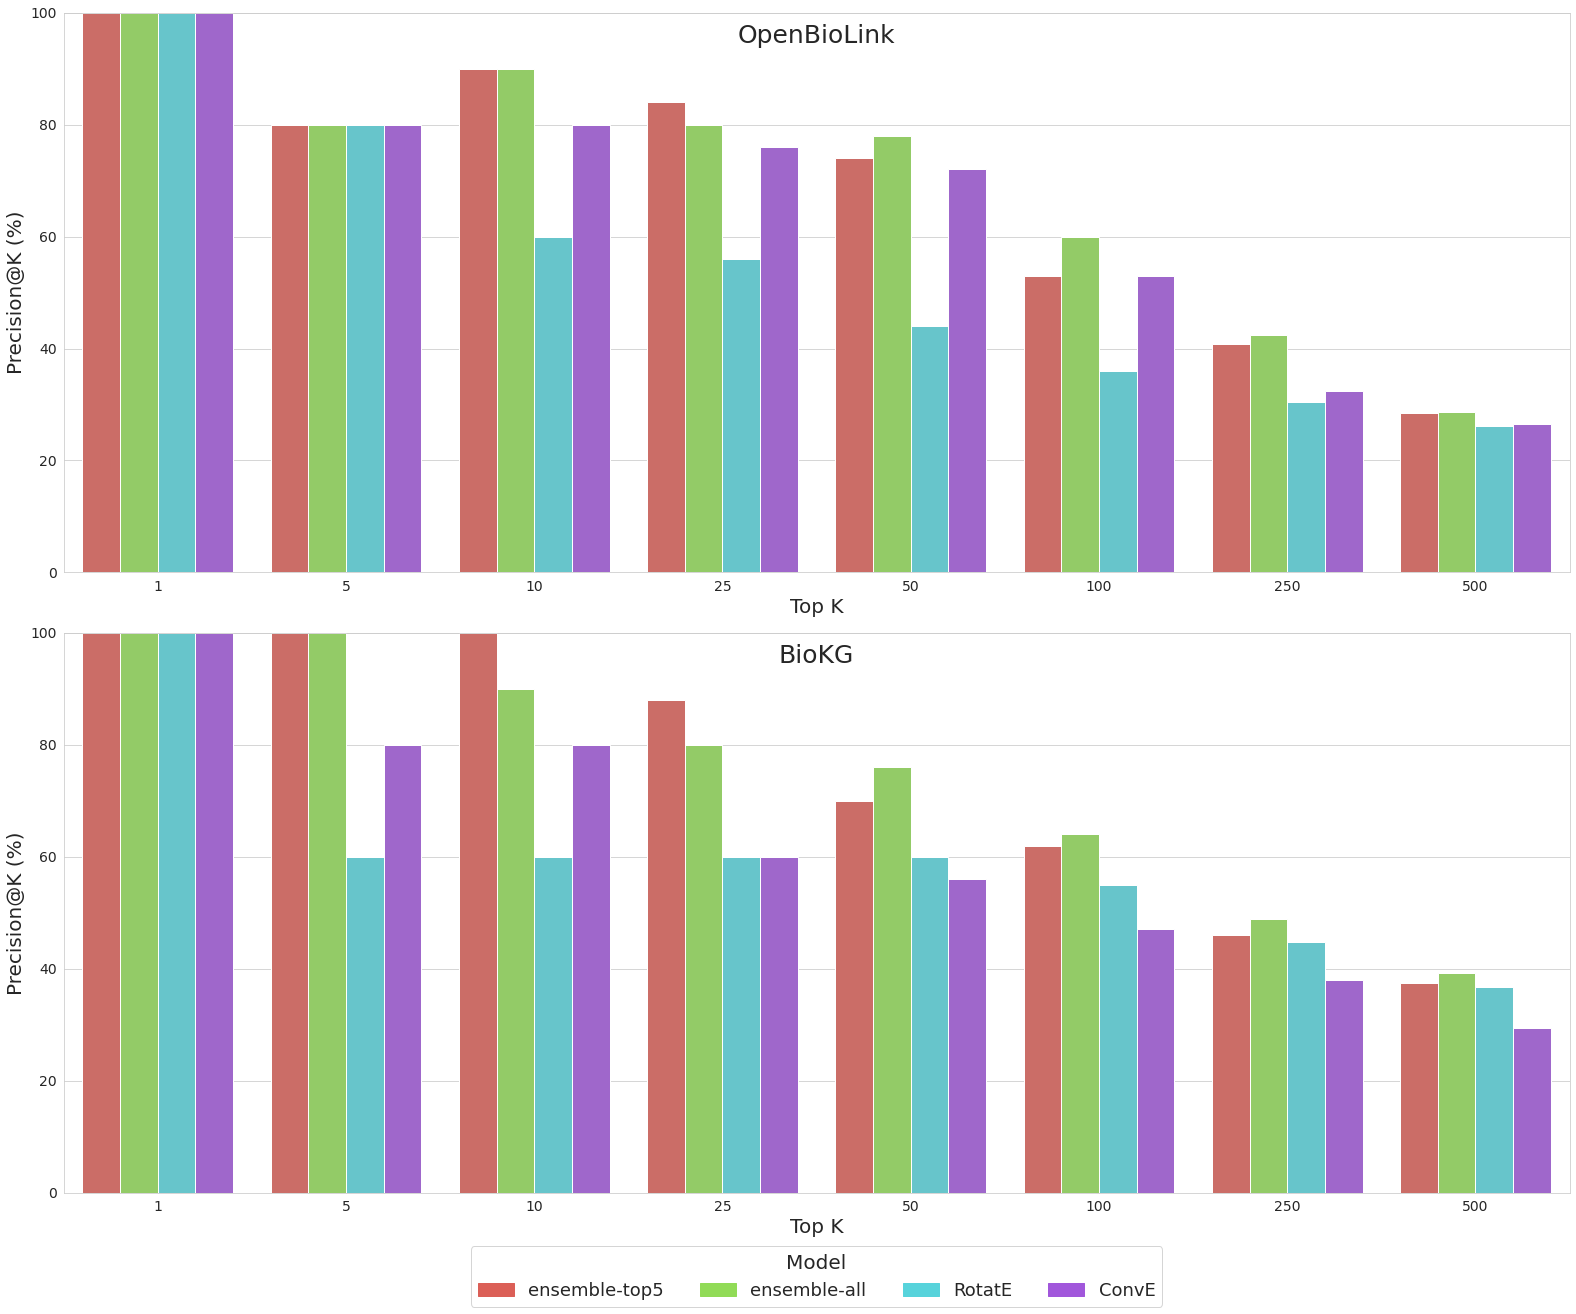

In [11]:
models = ['rotate', 'conve', 'ensemble-top5', 'ensemble-all']

plot_precision_at_K(
    df=all_precisions[all_precisions['model'].isin(models)].copy(),
    save_to="ensembles_vs_best.png"
)

## Ensembles' precision: Sum aggregation vs. Average aggregation

In [12]:
ensembles_precision_avg_fn = os.path.join(PREDICTIONS_PATH, 'ensembles_avg_agg_precision.csv')

if os.path.exists(ensembles_precision_avg_fn):
    ensembles_precision_avg = pd.read_csv(ensembles_precision_avg_fn, sep='\t')
else:
    data = []
    for kg in predictions.kg.unique():
        df_kg = predictions[predictions['kg'] == kg]

        for ensemble_id, ensemble_models in ensembles.items():
            df_models = df_kg[df_kg['model'].isin(ensemble_models)].copy().reset_index()

            score_combination_predictions_fn = os.path.join(PREDICTIONS_PATH, f'score_combination_preds-{kg}-{ensemble_id}-avg.csv')
            if not os.path.exists(score_combination_predictions_fn):
                score_combination_predictions = combine_scores_avg(df_models)
                score_combination_predictions["kg"] = kg
                score_combination_predictions["model"] = ensemble_id
                score_combination_predictions.to_csv(score_combination_predictions_fn, sep='\t', index=False)
            else:
                score_combination_predictions = pd.read_csv(score_combination_predictions_fn, sep='\t')

            for K in K_values:
                pr = get_precision(score_combination_predictions, K)
                data.append([kg, f'{ensemble_id} (Avg)', K, pr])

    ensembles_precision_avg = pd.DataFrame(
        data,
        columns=['kg', 'model', 'K', 'precision']
    )
    ensembles_precision_avg.to_csv(ensembles_precision_avg_fn, sep='\t', index=False)

In [13]:
all_ensembles_precision = pd.concat([ensembles_precision, ensembles_precision_avg], ignore_index=True)

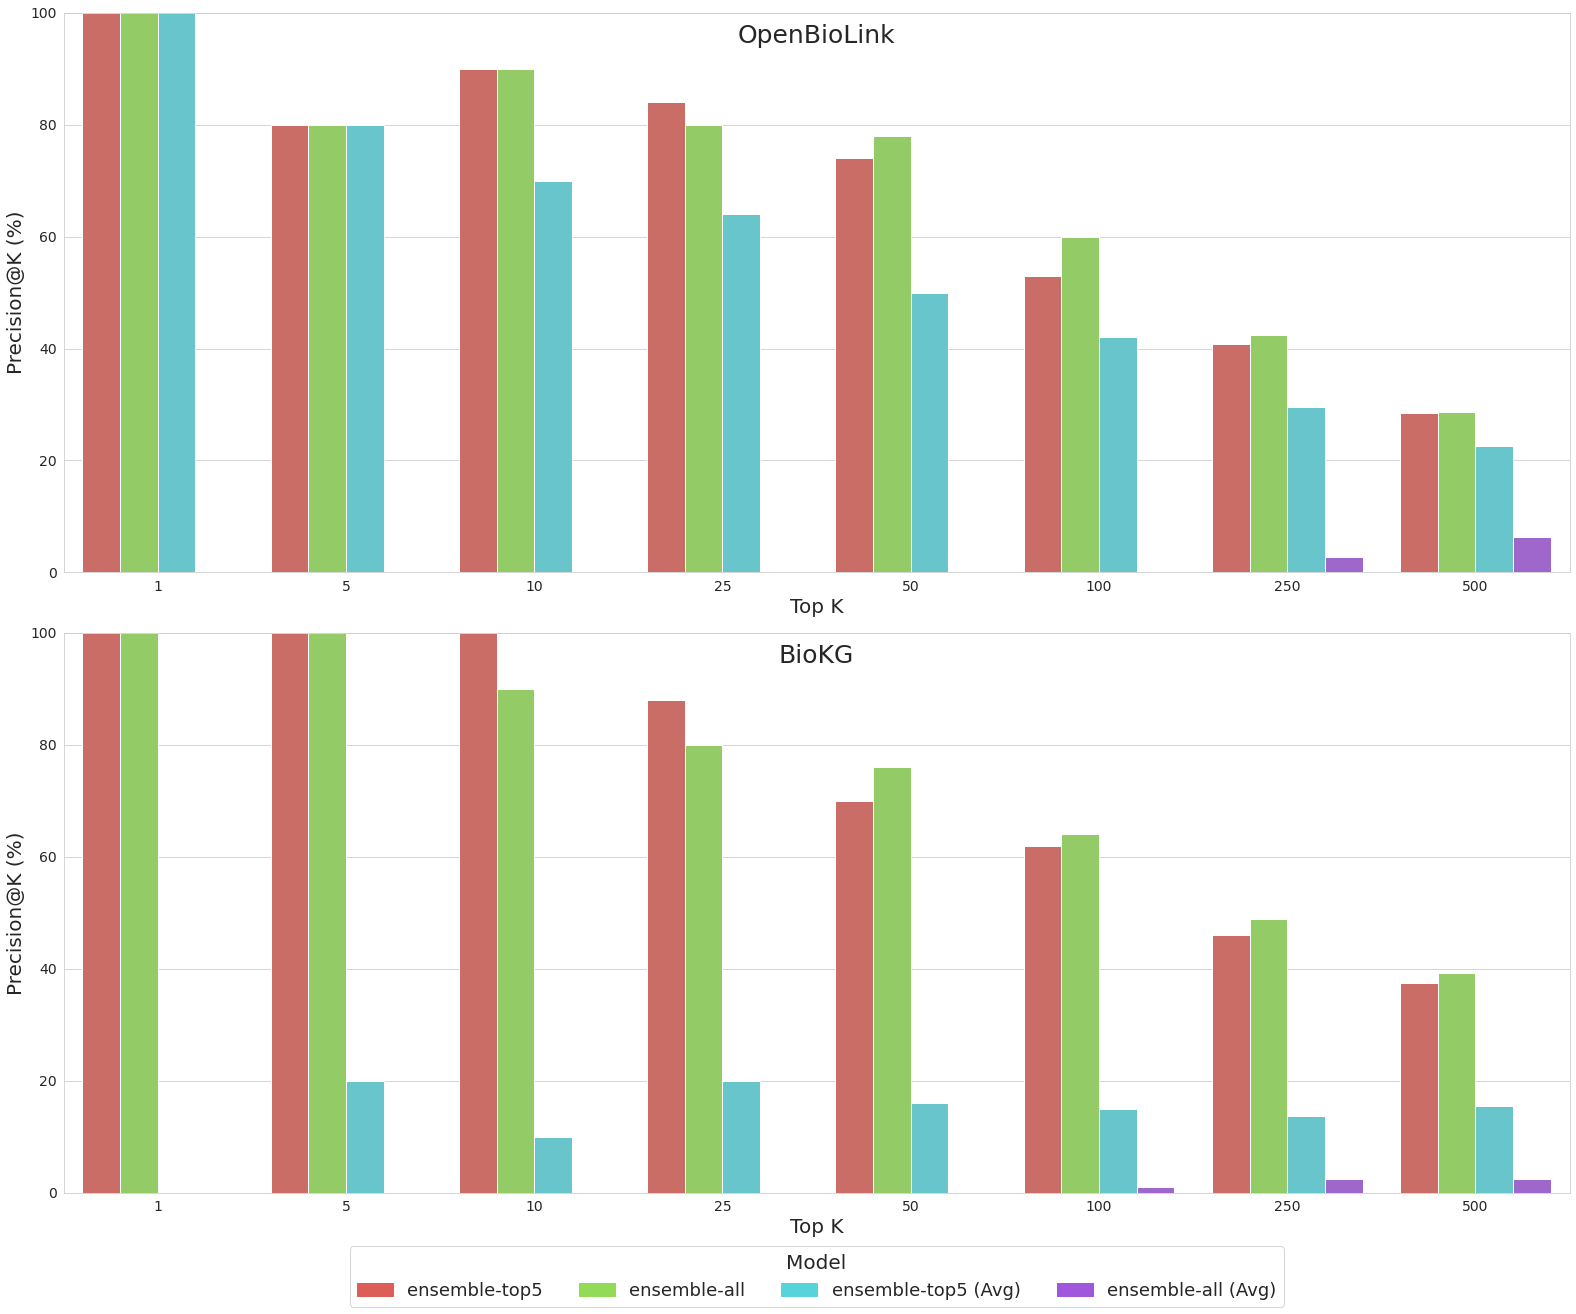

In [14]:
plot_precision_at_K(
    df=all_ensembles_precision.copy(),
    save_to="ensemble_vs_agg_avg.png",
    hue_order=['ensemble-top5', 'ensemble-all', 'ensemble-top5 (Avg)', 'ensemble-all (Avg)'],
)